In [4]:
import numpy as np
import os
import pickle

def read_pgm(filename):
    with open(filename, 'rb') as f:
        header = f.readline()
        if header != b'P5\n':
            raise ValueError("Invalid PGM file")
        width, height = map(int, f.readline().split())
        max_val = int(f.readline())
        img = np.fromfile(f, dtype=np.uint8, count=width*height)
        img = img.reshape((height, width))
    return img

def flatten_image(image):
    return image.flatten()

def create_hopfield_network(images):
    num_images, image_size = len(images), len(images[0])
    weight_matrix = np.zeros((image_size, image_size))
    for img in images:
        weight_matrix += np.outer(img, img)
    np.fill_diagonal(weight_matrix, 0)  # Set diagonal to zero
    weight_matrix /= num_images
    # Normalize the weight matrix to have a mean of zero and unit variance
    weight_matrix -= np.mean(weight_matrix)
    weight_matrix /= np.std(weight_matrix)
    return weight_matrix

def save_hopfield_network(weight_matrix, filename):
    with open(filename, 'wb') as f:
        pickle.dump(weight_matrix, f)

def create_and_save_hopfield_network(pgm_files, num_images, output_filename):
    # Read PGM files
    images = [flatten_image(read_pgm(file)) for file in pgm_files[:num_images]]

    # Create Hopfield network
    hopfield_network = create_hopfield_network(images)

    # Save Hopfield network to file
    save_hopfield_network(hopfield_network, output_filename)
    print(f"Hopfield network with {num_images} images saved to {output_filename}")

# Directory containing PGM files
pgm_dir = 'binary_64x64_real_pgm'
pgm_files = [os.path.join(pgm_dir, f) for f in os.listdir(pgm_dir) if f.endswith('.pgm')]

# Number of images to use for each Hopfield network
num_images_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

for num_images in num_images_list:
    output_filename = f'hopfield_network_real_{num_images}.pkl'
    create_and_save_hopfield_network(pgm_files, num_images, output_filename)


Hopfield network with 2 images saved to hopfield_network_real_2.pkl
Hopfield network with 4 images saved to hopfield_network_real_4.pkl
Hopfield network with 6 images saved to hopfield_network_real_6.pkl
Hopfield network with 8 images saved to hopfield_network_real_8.pkl
Hopfield network with 10 images saved to hopfield_network_real_10.pkl
Hopfield network with 12 images saved to hopfield_network_real_12.pkl
Hopfield network with 14 images saved to hopfield_network_real_14.pkl
Hopfield network with 16 images saved to hopfield_network_real_16.pkl
Hopfield network with 18 images saved to hopfield_network_real_18.pkl
Hopfield network with 20 images saved to hopfield_network_real_20.pkl


In [8]:
import numpy as np
import os
import pickle

def read_pgm(filename):
    with open(filename, 'rb') as f:
        header = f.readline()
        width, height = map(int, f.readline().split())
        max_val = int(f.readline().strip())
        image_data = []
        for _ in range(height):
            row = []
            for _ in range(width):
                row.append(int.from_bytes(f.read(1), 'big'))
            image_data.append(row)
    return width, height, max_val, image_data

def load_hopfield_network(filename):
    with open(filename, 'rb') as f:
        hopfield_network = pickle.load(f)
    return hopfield_network

def flatten_image(image_data):
    return np.array(image_data).flatten()

def recover_image(image_data, hopfield_network, max_iterations=100):
    recovered_image = np.copy(flatten_image(image_data))
    num_pixels = len(recovered_image)
    for _ in range(max_iterations):
        for i in range(num_pixels):
            sum_weights = np.dot(hopfield_network[i], recovered_image)
            recovered_image[i] = 255 if sum_weights > 0 else 0
    return recovered_image.reshape(len(image_data), len(image_data[0]))

def save_pgm(filename, width, height, max_val, image_data):
    with open(filename, 'wb') as f:
        f.write(b'P5\n')
        f.write(f"{width} {height}\n".encode())
        f.write(f"{max_val}\n".encode())
        for row in image_data:
            for pixel in row:
                f.write(bytes([pixel]))

def process_pgm_with_networks(input_filename, output_dir, hopfield_networks):
    width, height, max_val, image_data = read_pgm(input_filename)
    for num_images, network in hopfield_networks.items():
        recovered_image_data = recover_image(image_data, network)
        output_filename = os.path.join(output_dir, f"processed_real_pgm_{num_images}/{os.path.basename(input_filename)}")
        os.makedirs(os.path.dirname(output_filename), exist_ok=True)
        save_pgm(output_filename, width, height, max_val, recovered_image_data)

# Load all versions of Hopfield networks
hopfield_networks = {}
for num_images in range(2, 22, 2):
    hopfield_network_filename = f'hopfield_network_real_{num_images}.pkl'
    hopfield_networks[num_images] = load_hopfield_network(hopfield_network_filename)

# Directory containing input PGM files
input_dir = 'binary_32to64_real_pgm'

# Directory to save recovered PGM files
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Process each input PGM file with all versions of the Hopfield networks
for file in os.listdir(input_dir):
    if file.endswith('.pgm'):
        input_filename = os.path.join(input_dir, file)
        process_pgm_with_networks(input_filename, output_dir, hopfield_networks)

print("Recovery of PGM files complete. Recovered files saved in", output_dir)


Recovery of PGM files complete. Recovered files saved in output


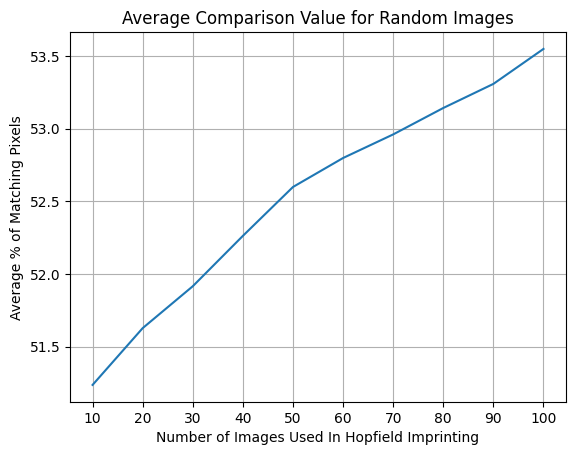

In [31]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def compare_images(image1, image2):
    image_array1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    image_array2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)

    if image_array1.shape != image_array2.shape:
        print("Error: different dimensions")
        return None

    matching_pixels = np.sum(image_array1 == image_array2)

    total_pixels = image_array1.shape[0] * image_array1.shape[1]
    matching_percentage = (matching_pixels / total_pixels) * 100

    return matching_percentage

def calculate_average_comparison(png_dir, pgm_dir):
    # Get the list of files in the directories
    png_files = sorted(os.listdir(png_dir))
    pgm_files = sorted(os.listdir(pgm_dir))

    # Ensure that both directories have the same number of images
    if len(png_files) != len(pgm_files):
        print("Error: Different number of images in the directories.")
        return

    total_comparison_values = []
    for png_file, pgm_file in zip(png_files, pgm_files):
        png_path = os.path.join(png_dir, png_file)
        pgm_path = os.path.join(pgm_dir, pgm_file)

        matching_percentage = compare_images(png_path, pgm_path)
        if matching_percentage is not None:
            total_comparison_values.append(matching_percentage)

    if total_comparison_values:
        average_comparison = np.mean(total_comparison_values)
        return average_comparison
    else:
        return None

# Directory containing generated PNG files for each version of Hopfield network
hopfield_png_dirs = {
    10: "./output/processed_pgm_10/",
    20: "./output/processed_pgm_20/",
    30: "./output/processed_pgm_30/",
    40: "./output/processed_pgm_40/",
    50: "./output/processed_pgm_50/",
    60: "./output/processed_pgm_60/",
    70: "./output/processed_pgm_70/",
    80: "./output/processed_pgm_80/",
    90: "./output/processed_pgm_90/",
    100: "./output/processed_pgm_100/"
}

# Directory containing original PGM files
pgm_dir = "./binary_64x64_pgm/"

# Calculate average comparison for each version of Hopfield network
hopfield_versions = []
average_comparisons = []
for num_images, png_dir in hopfield_png_dirs.items():
    average_comparison = calculate_average_comparison(png_dir, pgm_dir)
    if average_comparison is not None:
        hopfield_versions.append(num_images)
        average_comparisons.append(average_comparison)

# Plotting the graph
plt.plot(hopfield_versions, average_comparisons)
plt.xticks(hopfield_versions) 
plt.xlabel('Number of Images Used In Hopfield Imprinting')
plt.ylabel('Average % of Matching Pixels')
plt.title('Average Comparison Value for Random Images')
plt.grid(True)
plt.show()


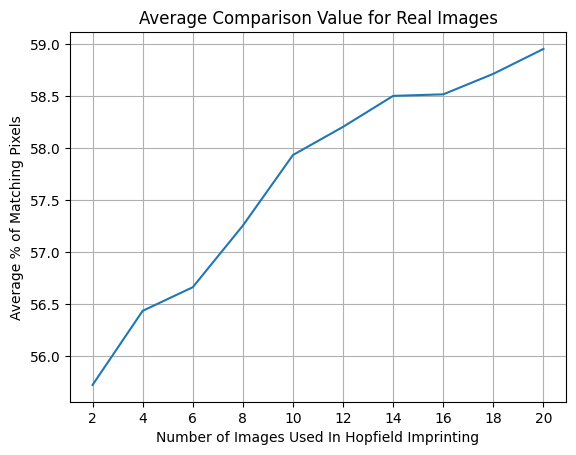

In [32]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def compare_images(image1, image2):
    image_array1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    image_array2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)

    if image_array1.shape != image_array2.shape:
        print("Error: different dimensions")
        return None

    matching_pixels = np.sum(image_array1 == image_array2)

    total_pixels = image_array1.shape[0] * image_array1.shape[1]
    matching_percentage = (matching_pixels / total_pixels) * 100

    return matching_percentage

def calculate_average_comparison(png_dir, pgm_dir):
    # Get the list of files in the directories
    png_files = sorted(os.listdir(png_dir))
    pgm_files = sorted(os.listdir(pgm_dir))

    # Ensure that both directories have the same number of images
    if len(png_files) != len(pgm_files):
        print("Error: Different number of images in the directories.")
        return

    total_comparison_values = []
    for png_file, pgm_file in zip(png_files, pgm_files):
        png_path = os.path.join(png_dir, png_file)
        pgm_path = os.path.join(pgm_dir, pgm_file)

        matching_percentage = compare_images(png_path, pgm_path)
        if matching_percentage is not None:
            total_comparison_values.append(matching_percentage)

    if total_comparison_values:
        average_comparison = np.mean(total_comparison_values)
        return average_comparison
    else:
        return None

# Directory containing generated PNG files for each version of Hopfield network
hopfield_png_dirs = {
    2: "./output/processed_real_pgm_2/",
    4: "./output/processed_real_pgm_4/",
    6: "./output/processed_real_pgm_6/",
    8: "./output/processed_real_pgm_8/",
    10: "./output/processed_real_pgm_10/",
    12: "./output/processed_real_pgm_12/",
    14: "./output/processed_real_pgm_14/",
    16: "./output/processed_real_pgm_16/",
    18: "./output/processed_real_pgm_18/",
    20: "./output/processed_real_pgm_20/"
}

# Directory containing original PGM files
pgm_dir = "./binary_64x64_real_pgm/"

# Calculate average comparison for each version of Hopfield network
hopfield_versions = []
average_comparisons = []
for num_images, png_dir in hopfield_png_dirs.items():
    average_comparison = calculate_average_comparison(png_dir, pgm_dir)
    if average_comparison is not None:
        hopfield_versions.append(num_images)
        average_comparisons.append(average_comparison)

# Plotting the graph
plt.plot(hopfield_versions, average_comparisons)
plt.xticks(hopfield_versions) 
plt.xlabel('Number of Images Used In Hopfield Imprinting')
plt.ylabel('Average % of Matching Pixels')
plt.title('Average Comparison Value for Real Images')
plt.grid(True)
plt.show()

In [33]:

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def compare_images(image1, image2):
    image_array1 = cv2.imread(image1, cv2.IMREAD_GRAYSCALE)
    image_array2 = cv2.imread(image2, cv2.IMREAD_GRAYSCALE)

    if image_array1.shape != image_array2.shape:
        print("Error: different dimensions")
        return None

    matching_pixels = np.sum(image_array1 == image_array2)

    total_pixels = image_array1.shape[0] * image_array1.shape[1]
    matching_percentage = (matching_pixels / total_pixels) * 100

    return matching_percentage

def calculate_average_comparison(dir1, dir2):
    # Get the list of files in the directories
    files1 = sorted(os.listdir(dir1))
    files2 = sorted(os.listdir(dir2))

    # Ensure that both directories have the same number of images
    if len(files1) != len(files2):
        print("Error: Different number of images in the directories.")
        return

    total_comparison_values = []
    for file1, file2 in zip(files1, files2):
        path1 = os.path.join(dir1, file1)
        path2 = os.path.join(dir2, file2)

        matching_percentage = compare_images(path1, path2)
        if matching_percentage is not None:
            total_comparison_values.append(matching_percentage)

    if total_comparison_values:
        average_comparison = np.mean(total_comparison_values)
        return average_comparison
    else:
        return None

# Directories containing images to compare
dir1 = "./binary_64x64_pgm/"
dir2 = "./binary_32to64_pgm/"

# Calculate average comparison between the images in the directories
average_comparison = calculate_average_comparison(dir1, dir2)

if average_comparison is not None:
    print("Average comparison value between the noise images:", average_comparison)
else:
    print("No comparison value could be calculated.")

# Directories containing images to compare
dir1 = "./binary_64x64_real_pgm/"
dir2 = "./binary_32to64_real_pgm/"

# Calculate average comparison between the images in the directories
average_comparison = calculate_average_comparison(dir1, dir2)

if average_comparison is not None:
    print("Average comparison value between the real images:", average_comparison)
else:
    print("No comparison value could be calculated.")

Average comparison value between the noise images: 68.7451171875
Average comparison value between the real images: 93.62060546875
